# Coding Notebook for Phase 2 project
## Soo Ho (John) Park, Nicholas Wertz, Nicholas Kennedy

## Importing of libraries

In [5]:
# these packages are used in our analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
import geopy.distance as geo
import datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.dummy import DummyRegressor
from IPython import display
from sklearn.metrics import r2_score
from statsmodels.tools.eval_measures import rmse
from IPython.display import Image
%matplotlib inline

# Introduction

King County is one of the most coveted real estate areas in Washington state, especially as the metropolitan hub of Seattle attracts more and more people. Our stakeholder is a house-flipping company that aims to buy real estate in its original condition at the lowest price possible and quickly sell it to a new buyer at a profit after renovation. However, due to the sheer number of homes and a fluctuating market, our stakeholder is having a difficult time estimating current house prices. What homes can be “flipped” and yield the highest profits?

The KaPow Consulting Team, comprised of data scientists, can offer a set of recommendations tailored to a house-flipper’s needs by utilizing a multiple regression model as a predictive measure. We analyze which indicators can predict the market sale price of a home and find which undervalued homes have the potential to be sold at a higher price. First, our data analysis found that price is heavily influenced by the size of living space, closeness to water, and whether the home is in the Northwest or West regions of King County. From our predictive multiple regression model, we then ascertained a series of undervalued homes that had a higher predicted value than the actual value it was sold. Analyzing a case study that meets the criteria of an undervalued home, we show how much potential profit could be made. By following these recommendations, our stakeholders can make more informed decisions when investing in undervalued homes with a high potential for profit. 

![King County Flag](pictures/Flag_of_King_County,_Washington.svg.png)


# Data Understanding
Our original data set, `kc_house_data.csv` contained 21597 home sales with 21 columns from 2014-2015 in King County, Washington, the county comprised of Seattle and the surrounding areas. In addition to sale price and home id, 19 other standard descriptors of including square footage, location, grade, waterfront view etc were given for these some 20K data points. Of these sales, 353 were duplicates, meaning homes in this subset were sold more than once in the 2-year span. These sales are for 177 unique homes, a very small sample given our original data set. Nevertheless, these represent the only real data of house flipping in our set, and this is important for our House-Flipping stake-holders.  

# Data Preparation
### Data Cleaning: 
Starting data preparation, we first extracted and removed the duplicate ids, the set of our flipped homes into a separate dataset, resales_df.csv for more of a case-study-type analysis. <a href =https://github.com/soohojp/Phase2_Project/blob/main/old_notebooks/clean_and_FE.ipynb>https://github.com/soohojp/Phase2_Project/blob/main/old_notebooks/clean_and_FE.ipynb</a>, section 1.

With these removed and set aside, we then removed outliers that were 3 standard deviations away from the mean on the numerical variables with high variance except for our target variable, sale price. These measures reduced the size of our dataset to 21059 data points. Documentation on how this was done can be found in our git repo at <a href =https://github.com/soohojp/Phase2_Project/blob/main/old_notebooks/clean_and_FE.ipynb>https://github.com/soohojp/Phase2_Project/blob/main/old_notebooks/clean_and_FE.ipynb </a> section 4.

### Feature Engineering: 
After our EDA, we chose to engineer features based on geographic location: zip code, latitude and longitude. Zip code was binned and dummy- encoded to give us 3 new variables, `label_urban`, `label_suburban` and `label_rural`. Documentation in <a href =https://github.com/soohojp/Phase2_Project/blob/main/old_notebooks/clean_and_FE.ipynb>https://github.com/soohojp/Phase2_Project/blob/main/old_notebooks/clean_and_FE.ipynb </a>  section 2.

We also used latitude and longitude to engineer 2 additional features, region and waterfront distance. Geographical coordinates were binned and dummy encoded in 9 region variables. N, NE, E, SE, S, S, W, NW and central King County. <a href =https://github.com/soohojp/Phase2_Project/blob/main/old_notebooks/clean_and_FE.ipynb>https://github.com/soohojp/Phase2_Project/blob/main/old_notebooks/clean_and_FE.ipynb </a> section 3

We finally created variable for distance to waterfront which returned the distance to the nearest property with a waterfront view. To do this we first created a cooridinates column that contained both longitude and latitude as a tuple. Next we defined a function called closest_water(coordinate), that looked at the list of waterfront property coordinates, and returned the distance to the closest one given a set of coordinates. Mapping this function to our dataframe coordinates, we obtained the distance in km to the nearest waterfront property for all of our homes, and called this variable closest_water. Documentation found here: <a href =https://github.com/soohojp/Phase2_Project/blob/main/old_notebooks/clean_and_FE.ipynb>https://github.com/soohojp/Phase2_Project/blob/old_notebooks/main/clean_and_FE.ipynb </a>  section 5.

We merged all of this into a master data file which will proceed to use in our analysis

In [6]:
#reading our cleaned and enhanced dataset
df = pd.read_csv('data/master_data_2.csv')
df.drop('Unnamed: 0', axis=1, inplace=True) #dropping an extra column artifact
df.head(2) #checking the layout of the data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,closest_water,group_C,group_E,group_N,group_NE,group_NW,group_S,group_SE,group_SW,group_W
0,7129300520,10/13/2014,221900,3,1.00,1180,5650,1.0,NaN,NONE,...,0.680220,0,0,0,0,0,0,0,0,1
1,6414100192,12/9/2014,538000,3,2.25,2570,7242,2.0,NO,NONE,...,2.915718,0,0,0,0,1,0,0,0,0


## Exploring basics of our data

In [7]:
#converting to date time
df['date'] = pd.to_datetime(df['date'])

In [8]:
#checking the info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21059 entries, 0 to 21058
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              21059 non-null  int64         
 1   date            21059 non-null  datetime64[ns]
 2   price           21059 non-null  int64         
 3   bedrooms        21059 non-null  int64         
 4   bathrooms       21059 non-null  float64       
 5   sqft_living     21059 non-null  int64         
 6   sqft_lot        21059 non-null  int64         
 7   floors          21059 non-null  float64       
 8   waterfront      18748 non-null  object        
 9   view            20998 non-null  object        
 10  condition       21059 non-null  object        
 11  grade           21059 non-null  int64         
 12  sqft_above      21059 non-null  int64         
 13  sqft_basement   21059 non-null  object        
 14  yr_built        21059 non-null  int64         
 15  yr

In [9]:
#looking at our basic metrics mean, median, count etc
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,yr_built,...,closest_water,group_C,group_E,group_N,group_NE,group_NW,group_S,group_SE,group_SW,group_W
count,2.105900e+04,2.105900e+04,21059.000000,21059.000000,21059.000000,2.105900e+04,21059.000000,21059.000000,21059.000000,21059.000000,...,21059.000000,21059.000000,21059.000000,21059.000000,21059.000000,21059.000000,21059.000000,21059.000000,21059.000000,21059.000000
mean,4.621894e+09,5.392477e+05,3.375279,2.114072,2071.458521,1.195228e+04,1.495133,7.654969,1779.117479,1970.897621,...,5.405509,0.117242,0.000047,0.124555,0.000760,0.395223,0.014151,0.000047,0.061161,0.286813
std,2.874741e+09,3.679167e+05,0.926421,0.765593,905.122712,2.686565e+04,0.540648,1.164359,815.290130,29.465601,...,5.782292,0.321716,0.006891,0.330221,0.027554,0.488910,0.118115,0.006891,0.239632,0.452284
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,3.000000,370.000000,1900.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.146050e+09,3.200000e+05,3.000000,1.750000,1420.000000,5.001000e+03,1.000000,7.000000,1190.000000,1951.000000,...,1.893041,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.975400e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.540000e+03,1.500000,7.000000,1560.000000,1975.000000,...,3.383900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.345000e+09,6.430000e+05,4.000000,2.500000,2540.000000,1.040000e+04,2.000000,8.000000,2200.000000,1997.000000,...,6.037817,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,12050.000000,1.164794e+06,3.500000,13.000000,8860.000000,2015.000000,...,57.486122,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
#checking the median of our home prices
df.price.median()

450000.0

### Low hanging fruit metrics
Given our business problem, we focus on sale price, we can see from above that the average home price is about 540K, and our median price is 450K

# Visulizing correlation and linearity
### Heatmap and pairplot

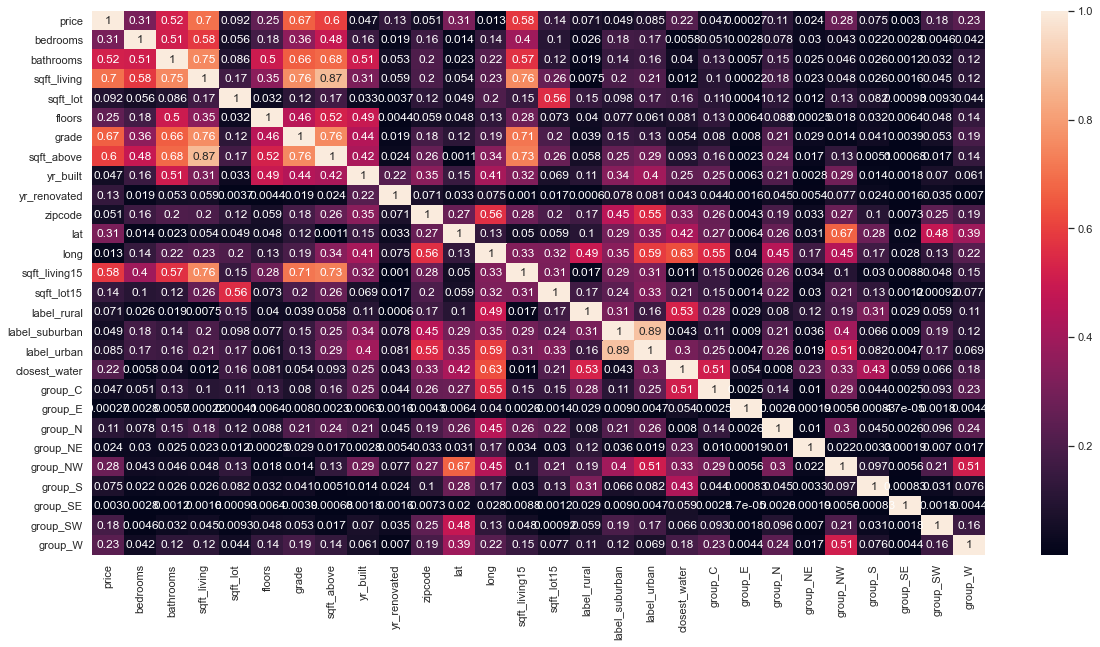

In [11]:
# Exploring correlation and linearity in our dataset with a HEATMAP
sns.set(rc = {'figure.figsize': (20,10)})
sns.heatmap(df.drop('id', axis=1).corr().abs(), annot=True);

Above we see that `bedrooms`, `bathrooms`, `sqft_living`, `floors`, `grade`, `sqft_above`, `lat`, `sqft_living15`, and `closest_water` all have Pearson Correlation coefficients above 0.2, which makes them metrics of interest for our model. We've also decided to eliminate most of the regions, since they did not make a significant impact on the price.

### Exploring Linearity and normality of our data with a pairplot
We will reduce the metrics to those of interest and those that have been engineered

In [12]:
#creating a list of our metrics of interest
metrics_list = ['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_above', 'floors', 'grade', 'long','lat',
                'sqft_living15', 'label_rural', 'label_urban', 'label_suburban', 'closest_water',
                'group_NW','group_SW','group_W']

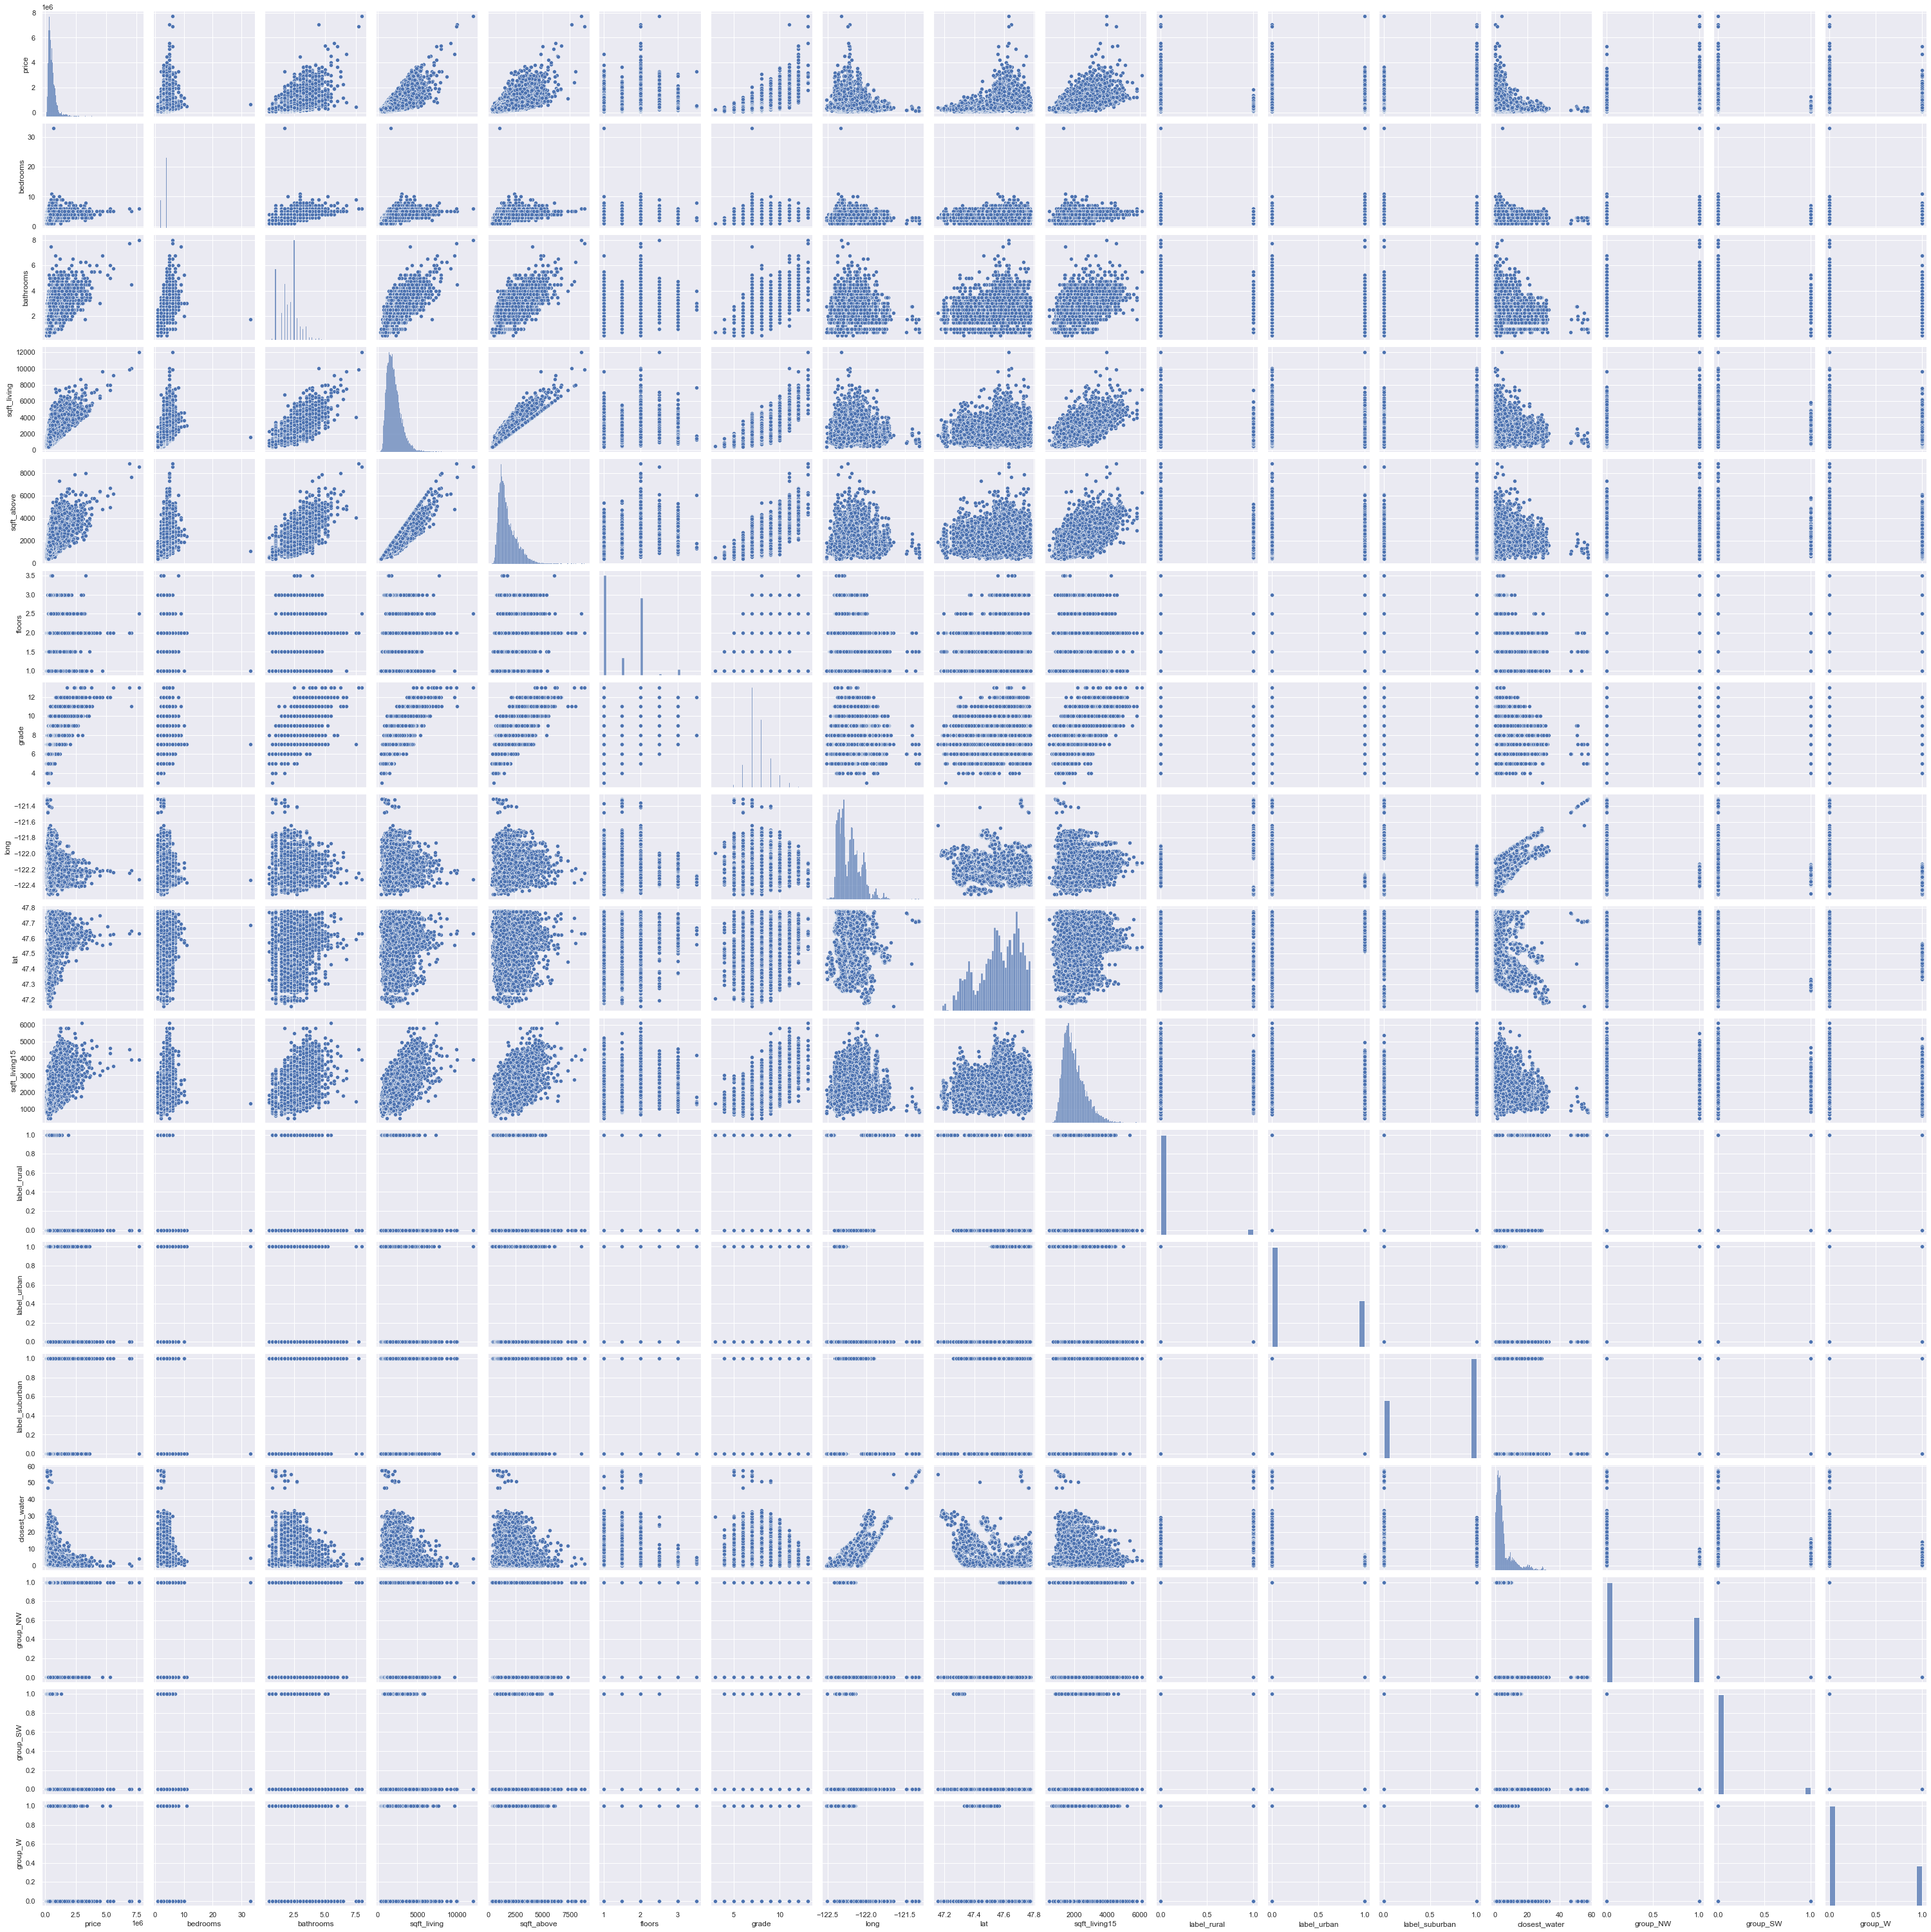

In [21]:
#passing the list into the pairplot
sns.pairplot(df[metrics_list]);

# Baseline Model
### Splitting our train and test data 8:2 ratio

In [13]:
y = df.price
X = df[metrics_list].drop('price', axis=1) # dropped yr_renovated because of its null values

#Creating our test split. 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2,
                                                    random_state=33)

## Creating our dummy regression baseline model using mean price

In [14]:
#Dummy Regressor

dummy_regr = DummyRegressor(strategy = 'mean')
dummy_regr.fit(X_train, y_train)
dummy_regr.predict(X_train) # looks at our predictions

array([538487.51118894, 538487.51118894, 538487.51118894, ...,
       538487.51118894, 538487.51118894, 538487.51118894])

Notice the above predictions of our price from our training data. All the predictions are the same, i.e. the mean price in this sample 
### Scoring to get R-squared

In [15]:
#scoring our baseline model 
dummy_regr.score(X_train, y_train)

0.0

This R-squared of 0 means that 0% of the variation in price is explained by this baseline model. We can do better:

# First Model: Linear Regression
### Scaling our Train data

In [16]:
ss = StandardScaler() # instatiate scaler object
ss.fit(X_train) # Fit it to train
X_preds_st_scaled = ss.transform(X_train) #transforming and saving it as a scaled train data object

X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

### Fitting it to our linear regression  

In [17]:
lr = LinearRegression()
lr.fit(X_preds_st_scaled, y_train)
lr.coef_
lr.score(X_preds_st_scaled, y_train)

0.6669347136607338

The above R-squared says that our model predicts 66.6% of the variation in home prices of our training data, now we see how it does on new data (our test)

### Trying the model on our test data

In [18]:
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)
lr.score(X_test_scaled, y_test)

0.6624889444095448

This works well. However, we used many different metrics for this model, which is likely too complex and impacted by multicolinearity
We examine in more detail using stats models

## Examining our first model

In order to get a more complete summary we use statsmodels, but first we need to manipulate our train data to the right format

In [19]:
#Reassembling our dataframe using scaled X values
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = df[metrics_list].drop('price', axis=1).columns
y_train.reset_index(drop=True,inplace=True)
X_train_scaled_final = pd.concat((X_train_scaled,y_train),axis=1)



In [20]:
#running the same model to get a detailed summary
outcome = 'price'
x_cols = df[metrics_list].drop('price', axis=1)
predictors = '+'.join(x_cols)
formula = 'price' + '~' + predictors
model2 = ols(formula=formula, data=X_train_scaled_final)
results = model2.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     2106.
Date:                Sat, 19 Feb 2022   Prob (F-statistic):               0.00
Time:                        16:14:03   Log-Likelihood:            -2.3036e+05
No. Observations:               16847   AIC:                         4.608e+05
Df Residuals:                   16830   BIC:                         4.609e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       5.385e+05   1618.832    332.641      0.000    5.35e+05    5.42e+05
bedrooms        -3.45e+04   2784.108    -12.393      0.000      -4e+04    -2.9e+04
bathrooms       7038.0448   2887.293      2.438      0.015    1378.647    1.27e+04
sqft_living     1.646e+05   4656.153     35.360      0.000    1.56e+05    1.74e+05
sqft_above      3.334e+04   4273.460      7.802      0.000     2.5e+04    4.17e+04
floors         -3.713e+04   2294.989    -16.179      0.000   -4.16e+04   -3.26e+04
grade           8.818e+04   2927.854     30.119      0.000    8.24e+04    9.39e+04
long            3.059e+04   3869.084      7.907      0.000     2.3e+04    3.82e+04
lat            -3.608e+04   3180.101    -11.345      0.000   -4.23e+04   -2.98e+04
sqft_living15    3.35e+04   2785.981     12.026      0.000     2.8e+04     3.9e+04
label_rural     4.971e+16   5.29e+16      0.940      0.347    -5.4e+16    1.53e+17
label_urban     1.034e+17    1.1e+17      0.940      0.347   -1.12e+17    3.19e+17
label_suburban  1.073e+17   1.14e+17      0.940      0.347   -1.17e+17    3.31e+17
closest_water  -7.768e+04   2856.672    -27.193      0.000   -8.33e+04   -7.21e+04
group_NW        8.396e+04   3471.171     24.188      0.000    7.72e+04    9.08e+04
group_SW       -3.908e+04   2577.406    -15.163      0.000   -4.41e+04    -3.4e+04
group_W        -2.364e+04   3192.356     -7.406      0.000   -2.99e+04   -1.74e+04
==============================================================================
Omnibus:                    14019.235   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           889166.785
Skew:                           3.604   Prob(JB):                         0.00
Kurtosis:                      37.853   Cond. No.                     2.29e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.58e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

We see that `label_urban` has a high p-value and should be removed from our model because it is not statistically significant enough to include.

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

In [22]:
print(vif_data)

           feature           VIF
0         bedrooms  1.635849e+00
1        bathrooms  2.960476e+00
2      sqft_living  8.221740e+00
3       sqft_above  6.883644e+00
4           floors  2.008351e+00
5            grade  3.272743e+00
6             long  5.714776e+00
7              lat  3.817158e+00
8    sqft_living15  2.971390e+00
9      label_rural  2.863912e+05
10     label_urban  1.751814e+06
11  label_suburban  3.487270e+06
12   closest_water  3.081943e+00
13        group_NW  4.568433e+00
14        group_SW  2.546119e+00
15         group_W  3.849799e+00


When assessing the VIF of each feature, we realize that `label_rural`, `label_urban`, and `label_suburban` have extremely high values. Since the VIFs for these aforementioned variables are way higher than 10, we can see that there is high multicollinearity. Thus, we decided to remove these features.

# Second Model

In [23]:
# defining the metrics used for our second model
metrics_list2 = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_above', 'floors', 'grade', 'lat',
              'sqft_living15', 'closest_water',
                'group_NW','group_SW','group_W']

In [24]:
y2 = df.price
X2 = df[metrics_list2].drop('price', axis=1) # dropped yr_renovated because of its null values

#Creating our test split. 80% train, 20% test
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, 
                                                    y2,
                                                    test_size=0.2,
                                                    random_state=33)

In [25]:
ss2 = StandardScaler() # instatiate scaler object
ss2.fit(X_train2) # Fit it to train
X_preds_st_scaled2 = ss2.transform(X_train2) #transforming and saving it as a scaled train data object

X_train_scaled2 = ss2.transform(X_train2)
X_test_scaled2 = ss2.transform(X_test2)

lr2 = LinearRegression()
lr2.fit(X_preds_st_scaled2, y_train2)
lr2.coef_
lr2.score(X_preds_st_scaled2, y_train2)

0.6555479164587934

In [26]:
#Reassembling our dataframe using scaled X values
X_train_scaled2 = pd.DataFrame(X_train_scaled2)
X_train_scaled2.columns = df[metrics_list2].drop('price', axis=1).columns
y_train2.reset_index(drop=True,inplace=True)
X_train_scaled_final2 = pd.concat((X_train_scaled2,y_train2),axis=1)

In [27]:
#running a second model, removing label_rural, label_urban, and label_suburban
outcome2 = 'price'
x_cols2 = df[metrics_list2].drop('price', axis=1).columns
predictors2 = '+'.join(x_cols2)
formula2 = 'price' + '~' + predictors2
model2 = ols(formula=formula2, data=X_train_scaled_final2)
results2 = model2.fit()
results2.summary() # returns a more detailed summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     2670.
Date:                Sat, 19 Feb 2022   Prob (F-statistic):               0.00
Time:                        16:14:09   Log-Likelihood:            -2.3065e+05
No. Observations:               16847   AIC:                         4.613e+05
Df Residuals:                   16834   BIC:                         4.614e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.385e+05   1646.022    327.145      0.000    5.35e+05    5.42e+05
bedrooms      -3.917e+04   2092.163    -18.721      0.000   -4.33e+04   -3.51e+04
bathrooms      3819.3958   2825.721      1.352      0.177   -1719.314    9358.106
sqft_living    1.797e+05   4653.150     38.623      0.000    1.71e+05    1.89e+05
sqft_above     1.513e+04   4220.495      3.586      0.000    6861.326    2.34e+04
floors        -2.477e+04   2254.236    -10.989      0.000   -2.92e+04   -2.04e+04
grade          8.992e+04   2970.606     30.270      0.000    8.41e+04    9.57e+04
lat           -2.329e+04   3110.407     -7.488      0.000   -2.94e+04   -1.72e+04
sqft_living15  2.559e+04   2771.023      9.236      0.000    2.02e+04     3.1e+04
closest_water -6.023e+04   2388.858    -25.213      0.000   -6.49e+04   -5.55e+04
group_NW       8.357e+04   2630.220     31.774      0.000    7.84e+04    8.87e+04
group_SW      -4.862e+04   2364.878    -20.560      0.000   -5.33e+04    -4.4e+04
group_W       -3.007e+04   2773.548    -10.840      0.000   -3.55e+04   -2.46e+04
==============================================================================
Omnibus:                    13581.587   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           782380.151
Skew:                           3.456   Prob(JB):                         0.00
Kurtosis:                      35.662   Cond. No.                         7.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From our second model, we can observe that the p-value for `bathrooms` is higher than the alpha, 0.05, meaning that a change in the  number of bathrooms does not have a statistically significant impact on the price. Thus, we decided the remove the `bathroom` feature from our model.

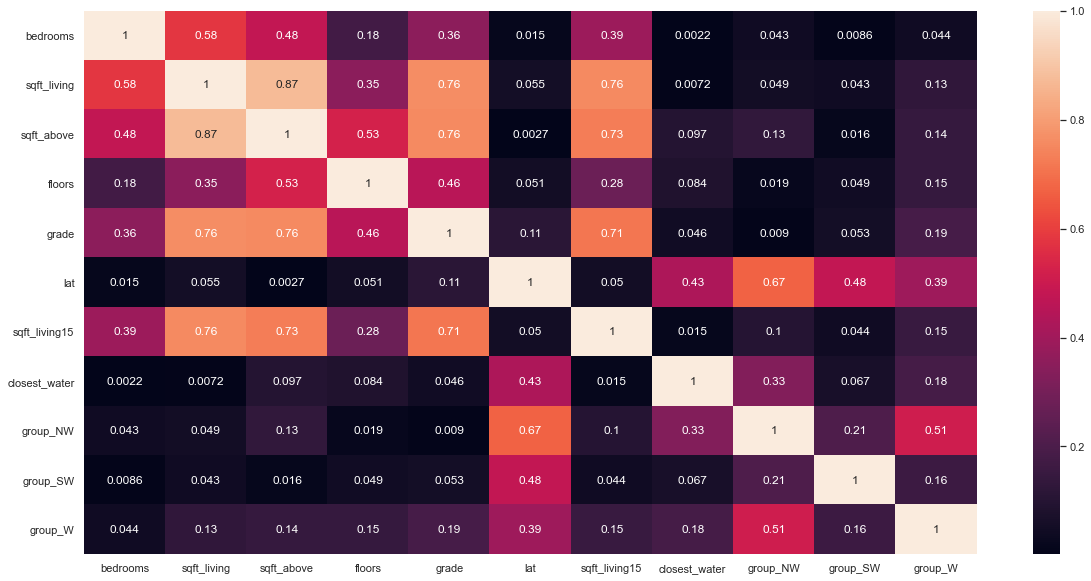

In [28]:
sns.heatmap(X_train_scaled.filter(['bedrooms', 'sqft_living', 'sqft_above', 'floors', 'grade', 'lat',
                'sqft_living15', 'closest_water',
                'group_NW','group_SW','group_W'],axis=1).corr().abs(),annot=True);


In order to check for multicolinearity, we conducted a heatmap with all of the features in the model. The correlation between `sqft_living` and `sqft_above` was very high at 0.87. This was foreseeable since the metric on `sqft_living` already includes `sqft_above`. `sqft_living` also had a high correlation of 0.76 with grade and 0.73 with `sqft_living15`. We decided to retain `sqft_living` instead of `sqft_above`, `grade`, and `sqft_living15` because it had the highest coefficient in relation to the price.

However, intuitively `grade` seems to be a great indicator for the quality of a house. Thus, we decided to take a closer look at the `grade` and how it affects the price after completing our model.

# Third Model

In [29]:
metrics_list3 = ['price', 'bedrooms', 'sqft_living', 'floors', 'lat','closest_water', 'group_NW','group_SW','group_W']

In [30]:
y3 = df.price
X3 = df[metrics_list3].drop('price', axis=1) 

#Creating our test split. 80% train, 20% test
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, 
                                                    y3,
                                                    test_size=0.2,
                                                    random_state=33)

In [31]:
ss3 = StandardScaler() # instatiate scaler object
ss3.fit(X_train3) # Fit it to train
X_preds_st_scaled3 = ss3.transform(X_train3) #transforming and saving it as a scaled train data object

X_train_scaled3 = ss3.transform(X_train3)
X_test_scaled3 = ss3.transform(X_test3)

#getting r-sqaured with sklearn for our train data
lr3 = LinearRegression()
lr3.fit(X_preds_st_scaled3, y_train3)
lr3.coef_
lr3.score(X_preds_st_scaled3, y_train3)

0.6259777806026976

In [32]:
#getting r-sqaured with sklearn for our test data
X_train_scaled3 = ss3.transform(X_train3)
X_test_scaled3 = ss3.transform(X_test3)
lr3.score(X_test_scaled3, y_test3)

0.6411706098467951

In [33]:
#Reassembling our dataframe using scaled X values
X_train_scaled3 = pd.DataFrame(X_train_scaled3)
X_train_scaled3.columns = df[metrics_list3].drop('price', axis=1).columns
y_train3.reset_index(drop=True,inplace=True)
X_train_scaled_final3 = pd.concat((X_train_scaled3,y_train3),axis=1)

In [34]:
# checking the summary stats of our model
outcome3 = 'price'
x_cols3 = df[metrics_list3].drop('price', axis=1).columns
predictors3 = '+'.join(x_cols3)
formula3 = 'price' + '~' + predictors3
model3 = ols(formula=formula3, data=X_train_scaled_final3)
results3 = model3.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     3523.
Date:                Sat, 19 Feb 2022   Prob (F-statistic):               0.00
Time:                        16:14:13   Log-Likelihood:            -2.3134e+05
No. Observations:               16847   AIC:                         4.627e+05
Df Residuals:                   16838   BIC:                         4.628e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.385e+05   1715.017    313.984      0.000    5.35e+05    5.42e+05
bedrooms      -5.127e+04   2113.396    -24.259      0.000   -5.54e+04   -4.71e+04
sqft_living    2.792e+05   2270.533    122.954      0.000    2.75e+05    2.84e+05
floors        -1294.1268   1853.165     -0.698      0.485   -4926.524    2338.270
lat            -2.48e+04   3234.627     -7.667      0.000   -3.11e+04   -1.85e+04
closest_water -7.172e+04   2447.619    -29.300      0.000   -7.65e+04   -6.69e+04
group_NW       7.002e+04   2638.619     26.536      0.000    6.48e+04    7.52e+04
group_SW      -5.504e+04   2450.902    -22.459      0.000   -5.98e+04   -5.02e+04
group_W       -4.861e+04   2828.047    -17.188      0.000   -5.42e+04   -4.31e+04
==============================================================================
Omnibus:                    12396.424   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           528599.019
Skew:                           3.088   Prob(JB):                         0.00
Kurtosis:                      29.737   Cond. No.                         4.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The feature `floors` has a p_value of 0.485, which is much higher than the alpha, 0.05. This mean that a change in the number of floors does not have a statistically significant influence on the price. Thus, we decided to remove `floors` in our model.

# Fourth Model

### Choosing to Log-Transform Distance to Water:
In looking at the distribution of `closest_water`, we see that it is not normally distributed: To make this feature better fit our assumptions for linear regression, we decided to take the log of distance to waterfront, which returned a more normal distribution. We also believe that using the log makes conceptual sense for this feature, as distance to water is much more impactful at closer distances, when you can walk, run and bike to it. It has increasingly, and non-linearly diminishing impact on home prices as the distance to water lengthens. We compare both regular and the log-transformed distance to waterfront below to show how it better meets our assumptions for linear regression.

In [35]:
#Creating the variable log_Water, the log-transformed distance to waterfront
df['log_water'] = np.log(df['closest_water'] + 0.01)

We add the constant 0.01 km to our log transform to account for the waterfront properties that have values of 0 km, since the value log(0) is undefined
### Comparing our assumptions for linear regression visually:

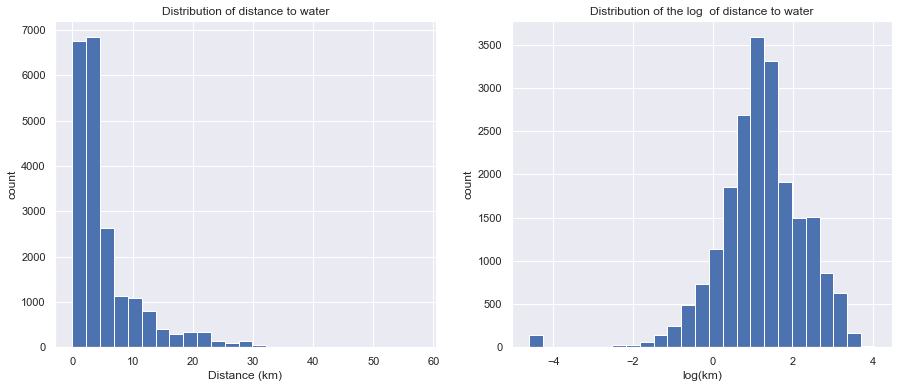

In [36]:
#Creating charts to look at the Distribution of Distance to water as is (Left), and after logarithmic 
#transformation (right)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,6))

ax1.hist(df['closest_water'], bins=25)
ax2.hist(df['log_water'], bins=25);
ax1.set(title = 'Distribution of distance to water', xlabel='Distance (km)', ylabel= 'count')
ax2.set(title = 'Distribution of the log  of distance to water', xlabel='log(km)', ylabel= 'count');

Notice above how the log transformed distance to water (Right) is much more successful at meeting our assumption of being normally distributed. With these to assumptions validated for the log transformed distance to water, we proceed to check the assumption of linearity below:

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


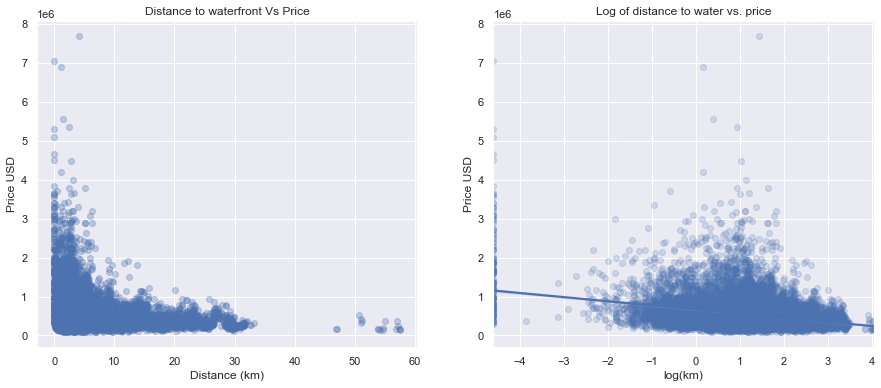

In [37]:
#Charts to look at the Linearty of Price Vs  Distance to water before (Left) after logarithmic transformation (right)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,6))

ax1.scatter(df['closest_water'], df['price'], alpha=0.3)
ax2 = sns.regplot(df['log_water'], df['price'], scatter_kws={'alpha':0.2})
ax1.set(title = 'Distance to waterfront Vs Price', xlabel='Distance (km)', ylabel= 'Price USD')
ax2.set(title = 'Log of distance to water vs. price', xlabel='log(km)', ylabel= 'Price USD');

Notice above how the log transformed distance to water (Right) is much more successful at meeting our assumption of linearity with our target variable, `price`. With these to assumptions validated for the log transformed distance to water, we choose this as our new variable instead of distance to water

In [38]:
#our new variables for the fourth model
metrics_list4 = ['price', 'bedrooms', 'sqft_living', 'lat','log_water', 'group_NW','group_SW','group_W']

In [39]:
#Running our model as we have done prior
y4 = df.price
X4 = df[metrics_list4].drop('price', axis=1) # 

#Creating our test split. 80% train, 20% test
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4,test_size=0.2, random_state=33)

ss4 = StandardScaler() # instatiate scaler object
ss4.fit(X_train4) # Fit it to train
X_preds_st_scaled4 = ss4.transform(X_train4) #transforming and saving it as a scaled train data object

X_train_scaled4 = ss4.transform(X_train4)
X_test_scaled4 = ss4.transform(X_test4)

#sklearn model our train
lr4 = LinearRegression()
lr4.fit(X_preds_st_scaled4, y_train4)
lr4.coef_
lr4.score(X_preds_st_scaled4, y_train4), lr4.score(X_test_scaled4, y_test4)

(0.6514429050624149, 0.6619324176375299)

In [40]:
#Reassembling our dataframe using scaled X values
X_train_scaled4 = pd.DataFrame(X_train_scaled4)
X_train_scaled4.columns = df[metrics_list4].drop('price', axis=1).columns
y_train4.reset_index(drop=True,inplace=True)
X_train_scaled_final4 = pd.concat((X_train_scaled4,y_train4),axis=1)

In [41]:
#running a fourth model, removing  sqft_above, grade, and sqft_living15
outcome4 = 'price'
x_cols4 = df[metrics_list4].drop('price', axis=1).columns
predictors4 = '+'.join(x_cols4)
formula4 = 'price' + '~' + predictors4
model4 = ols(formula=formula4, data=X_train_scaled_final4)
results4 = model4.fit()
results4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     4496.
Date:                Sat, 19 Feb 2022   Prob (F-statistic):               0.00
Time:                        16:14:23   Log-Likelihood:            -2.3075e+05
No. Observations:               16847   AIC:                         4.615e+05
Df Residuals:                   16839   BIC:                         4.616e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    5.385e+05   1655.556    325.261      0.000    5.35e+05    5.42e+05
bedrooms    -4.624e+04   2041.991    -22.644      0.000   -5.02e+04   -4.22e+04
sqft_living  2.702e+05   2109.449    128.072      0.000    2.66e+05    2.74e+05
lat         -1.161e+04   2759.125     -4.207      0.000    -1.7e+04   -6200.477
log_water    -8.92e+04   1920.671    -46.443      0.000    -9.3e+04   -8.54e+04
group_NW     7.023e+04   2483.159     28.284      0.000    6.54e+04    7.51e+04
group_SW    -4.305e+04   2150.902    -20.016      0.000   -4.73e+04   -3.88e+04
group_W     -4.614e+04   2390.776    -19.298      0.000   -5.08e+04   -4.15e+04
==============================================================================
Omnibus:                    11517.627   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           460526.143
Skew:                           2.775   Prob(JB):                         0.00
Kurtosis:                      28.005   Cond. No.                         3.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared for model #4 is a respectable 0.65, and all of our p-values are low enough to meet the criteria for significance. The model seems good, so we double check that we are not violating the assumption of multicolinearity by looking at VIF

### Checking the VIF for multicolinearty
We check the VIF to see if any other features should be removed from our model. VIF higher than 5 or 10 depending on stringency poses an issue for the soundness of our model.

In [42]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train4.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train4.values, i)
                          for i in range(len(X_train4.columns))]
print(vif_data)

       feature        VIF
0     bedrooms  21.488054
1  sqft_living  10.185865
2          lat  23.425961
3    log_water   2.743621
4     group_NW   3.036894
5     group_SW   1.259910
6      group_W   2.563917


We still see high VIF for bedrooms, and latitude as well as sqft_living have VIF of over 10, so the model has issues with multicolinearity. We reject and choose to create a new model. We decide to remove `bedrooms` and `lat`, keeping `sqft_living` as its our most strongly correlated variable to `price`.

In [43]:
#Reassembling our dataframe using scaled X values
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = df[metrics_list].drop('price', axis=1).columns
y_test.reset_index(drop=True,inplace=True)
X_test_scaled_final = pd.concat((X_test_scaled,y_test),axis=1)

# Final Model
Having removed the 2 variables with high variance inflation factors (VIF), we test our model again to see if we've successfully removed multicolinearty issues while maintaining a decent R-squared that explains price variation

In [44]:
#the vairables used in our final model
metrics_list5 = ['price', 'sqft_living', 'log_water', 'group_NW','group_SW','group_W']

In [45]:
y5 = df.price
X5 = df[metrics_list5].drop('price', axis=1) # 

#Creating our test split. 80% train, 20% test
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5,test_size=0.2, random_state=33)

ss5 = StandardScaler() # instatiate scaler object
ss5.fit(X_train5) # Fit it to train
X_preds_st_scaled5 = ss5.transform(X_train5) #transforming and saving it as a scaled train data object

X_train_scaled5 = ss5.transform(X_train5)
X_test_scaled5 = ss5.transform(X_test5)

#sklearn model our train
lr5 = LinearRegression()
lr5.fit(X_preds_st_scaled5, y_train5)
lr5.coef_
final_scores = lr5.score(X_preds_st_scaled5, y_train5), lr5.score(X_test_scaled5, y_test5)
print('(R^2 train, R^2 test) =' ,final_scores)# these our the R-scores for the train, and test data respectively

(R^2 train, R^2 test) = (0.6405450530969485, 0.6510963256573791)


In [46]:
#Reassembling our dataframe using scaled X values
X_train_scaled5 = pd.DataFrame(X_train_scaled5)
X_train_scaled5.columns = df[metrics_list5].drop('price', axis=1).columns
y_train5.reset_index(drop=True,inplace=True)
X_train_scaled_final5 = pd.concat((X_train_scaled5,y_train5),axis=1)

In [47]:
outcome5 = 'price'
x_cols5 = df[metrics_list5].drop('price', axis=1).columns
predictors5 = '+'.join(x_cols5)
formula5 = 'price' + '~' + predictors5
model5 = ols(formula=formula5, data=X_train_scaled_final5)
results5 = model5.fit()
results5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     6002.
Date:                Sat, 19 Feb 2022   Prob (F-statistic):               0.00
Time:                        16:14:31   Log-Likelihood:            -2.3101e+05
No. Observations:               16847   AIC:                         4.620e+05
Df Residuals:                   16841   BIC:                         4.621e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    5.385e+05   1681.138    320.311      0.000    5.35e+05    5.42e+05
sqft_living  2.425e+05   1745.745    138.883      0.000    2.39e+05    2.46e+05
log_water   -8.943e+04   1860.343    -48.070      0.000   -9.31e+04   -8.58e+04
group_NW     6.356e+04   2273.290     27.959      0.000    5.91e+04     6.8e+04
group_SW    -4.041e+04   1827.890    -22.107      0.000    -4.4e+04   -3.68e+04
group_W     -4.612e+04   2271.309    -20.306      0.000   -5.06e+04   -4.17e+04
==============================================================================
Omnibus:                    11829.682   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           501044.103
Skew:                           2.872   Prob(JB):                         0.00
Kurtosis:                      29.092   Cond. No.                         2.34
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Checking the VIF
Again we see if our assumption of no multicolinearity is violated. 

In [48]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train5.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train5.values, i)
                          for i in range(len(X_train5.columns))]
print(vif_data)

       feature       VIF
0  sqft_living  2.988070
1    log_water  1.834236
2     group_NW  1.712536
3     group_SW  1.130068
4      group_W  1.456175


### Deciding on this as our final model
The VIFs above are all under 5, meaning this model passes the test of multicolinearty. It's R-squared has not been reduced by much and we are now only using 5 variables. 4 of which are based simply off of geographic coordinates. It's simplicity gives it practical power, as these are all very easy to track. 

**64-65%** of the variation in `price` is explained by our model. We meet our assumptions for linear regression and proceed to further analyze it. Below we do a little data house-keeping

In [49]:
#settling on the final model and 
final_model = results5

In [50]:
# Setting up our final model data in a dataframe for later use
X_test_scaled5 = pd.DataFrame(X_test_scaled5)
X_test_scaled5.columns = df[metrics_list5].drop('price', axis=1).columns
y_test5.reset_index(drop=True,inplace=True)
X_test_scaled_final5 = pd.concat((X_test_scaled5,y_test5),axis=1)
X_test_scaled_final5.head(2)

,sqft_living,log_water,group_NW,group_SW,group_W,price
0,0.122484,1.588247,-0.806657,-0.255186,-0.63444,363000
1,-0.676551,-0.039187,1.239684,-0.255186,-0.63444,312000


### Unscaling our final model to gain additional insights with more conceptually-friendly coefficients
Next, we check our model on unscaled train-data to see how the coefficients look. 

In [51]:
#setting up our data for running the model
X_train6 = X_train5
X_train6.reset_index(drop=True,inplace=True)
X_train_final_unscaled = pd.concat((X_train6,y_train5),axis=1)

In [52]:
#running the model on unscaled X train
model_unscaled = ols(formula=formula5, data=X_train_final_unscaled)
results_unscaled = model_unscaled.fit()
results_unscaled.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     6002.
Date:                Sat, 19 Feb 2022   Prob (F-statistic):               0.00
Time:                        16:14:36   Log-Likelihood:            -2.3101e+05
No. Observations:               16847   AIC:                         4.620e+05
Df Residuals:                   16841   BIC:                         4.621e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    6.937e+04   6897.126     10.058      0.000    5.59e+04    8.29e+04
sqft_living   269.0692      1.937    138.883      0.000     265.272     272.867
log_water   -8.234e+04   1712.934    -48.070      0.000   -8.57e+04    -7.9e+04
group_NW     1.301e+05   4651.928     27.959      0.000    1.21e+05    1.39e+05
group_SW    -1.687e+05   7629.429    -22.107      0.000   -1.84e+05   -1.54e+05
group_W      -1.02e+05   5021.030    -20.306      0.000   -1.12e+05   -9.21e+04
==============================================================================
Omnibus:                    11829.682   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           501044.103
Skew:                           2.872   Prob(JB):                         0.00
Kurtosis:                      29.092   Cond. No.                     1.29e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Interpretation of our final model unscaled
- As you increase living area sq ft by 1, our model predicts an increase in price of almost \$270 USD
- As you descrease distance to water by 1%, our model predicts and increase in price of \$823 USD
- NW: being located in the NW region predicts a higher price by 13K USD
- SW: being located in the SW region predicts a lower price by 17K USD
- W: being located in the W region predicts a lower price by 10K USD

## Checking the R2 Test Data
Final verification of our model by again running it on our test data

In [53]:
#Reassembling our dataframe using scaled X values
X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = df[metrics_list].drop('price', axis=1).columns
y_test.reset_index(drop=True,inplace=True)
X_test_scaled_final = pd.concat((X_test_scaled,y_test),axis=1)
X_test_scaled_final.head(2)

,bedrooms,bathrooms,sqft_living,sqft_above,floors,grade,long,lat,sqft_living15,label_rural,label_urban,label_suburban,closest_water,group_NW,group_SW,group_W,price
0,0.668172,0.501111,0.122484,0.489489,0.93053,0.297049,1.046472,-1.406608,0.798426,-0.236027,-0.680290,0.764953,2.300023,-0.806657,-0.255186,-0.63444,363000
1,-1.478003,-1.460673,-0.676551,-0.638320,-0.91813,-0.562664,-0.726549,1.015308,-0.587041,-0.236027,1.469962,-1.307271,-0.384172,1.239684,-0.255186,-0.63444,312000


In [54]:
# Comparing R2 of model with test data

y_test_pred = final_model.predict(X_test_scaled_final5)
print('R2 of Model with Test Data:',round(r2_score(y_test5,y_test_pred),3))
print('R2 of Model with Train Data:',round(final_model.rsquared,3))

R2 of Model with Test Data: 0.651
R2 of Model with Train Data: 0.641


### Interpretatin Test Vs. Train
The R-squared of the model with the test data is very close to that of the train data. A close R-suqared value for both the train and test sets signify that the model is generalizing well. Thus, our final model exhibits qualities of a good model.

##  Calculating RSME
Here, we look at the root-mean-squared error, which gives us a value for on averege how much our predictions vary from the actual data in our sample

In [55]:
#checking our predictions vs. actual price values
y_hat_train = final_model.predict(X_train_scaled5)
print('Train RMSE:',rmse(y_train5,y_hat_train))
print('Test RMSE:',rmse(y_test5,y_test_pred))
print('Difference in RSME:', abs(rmse(y_train5,y_hat_train)-rmse(y_test5,y_test_pred)))

Train RMSE: 218166.06514908466
Test RMSE: 226561.15800524622
Difference in RSME: 8395.092856161558


### Interpreting RSME: 
To get a summarized measure over all the instances in the test and training set, we calculated the Root Mean Squared Error. A big difference in value between the test and training set RSME is an indication of overfitting. But, considering that prices of homes are in the thousands if not a million-dollar range, we deemed that the difference in RSME of 8606.85 is not that high.

The total RSME is fairly high for this model. Much if this may be caused by outliers in price, and also indicates our model's fit could improve. For future models we would look to reduce this error metric by including more variables that fit more accurately to real data. 

## Normal Distribution of Residuals

In [56]:
from statsmodels.api import qqplot

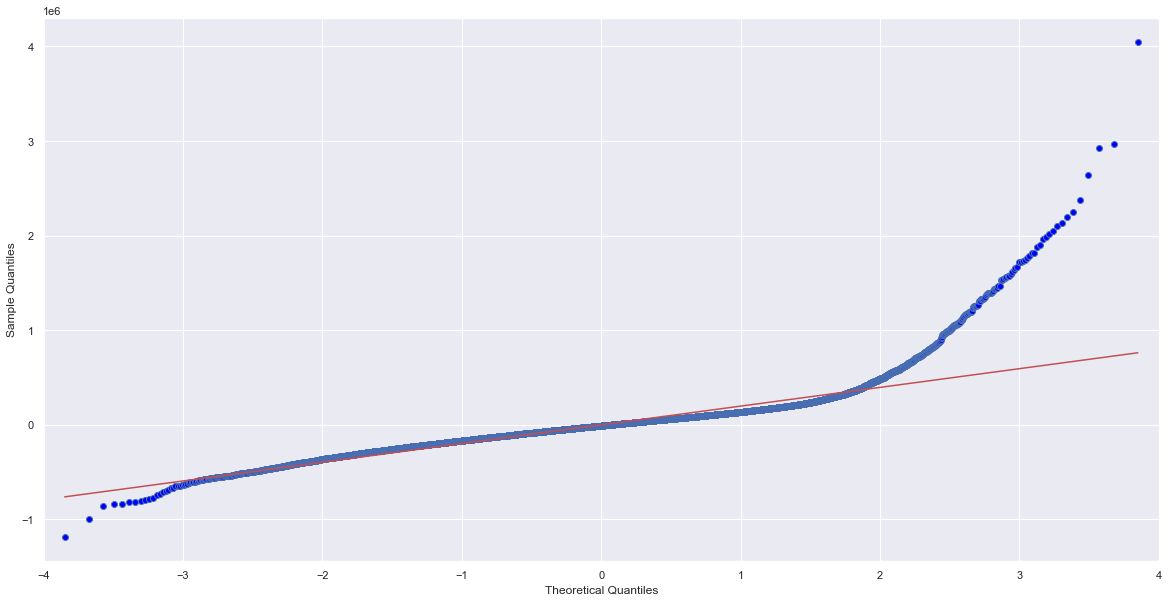

In [57]:
qqplot(y_train-y_hat_train,line='r')
plt.show()

Q-Q plots let you check that the data meet the assumption of normality. They compare the distribution of your data to a normal distribution by plotting the quartiles of your data against the quartiles of a normal distribution. If your data are normally distributed then they should form an approximately straight line. Notice the points fall along a line in the middle of the graph, but curve off in the extremities with heavy tails. This may suggest that the data may have outliers that fall beyond the model.

## Heteroskedasticity and Lack of Trend in Errors

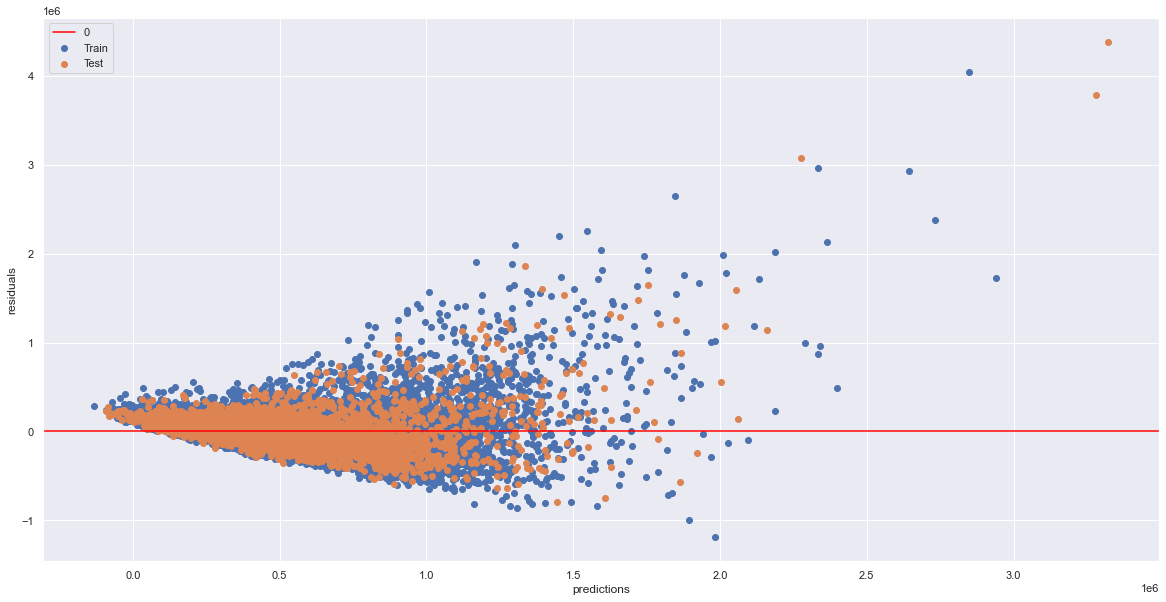

In [58]:


plt.scatter(y_hat_train, y_train - y_hat_train, label='Train')
plt.scatter(y_test_pred, y_test - y_test_pred, label='Test')

plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.legend()
plt.show()

Heteroscedasticity produces a distinctive fan or cone shape in residual plots, meaning that as the fitted values increases, the variance of the residual also increases. Heteroscedasticity is a problem because OLS regression assumes that all residuals are drawn from a population that has a constant variance. As we can see from the graph above, there is a slight cone shape, meaning that there may be some heteroscedasticity.

# Multicolinearity

<AxesSubplot:>

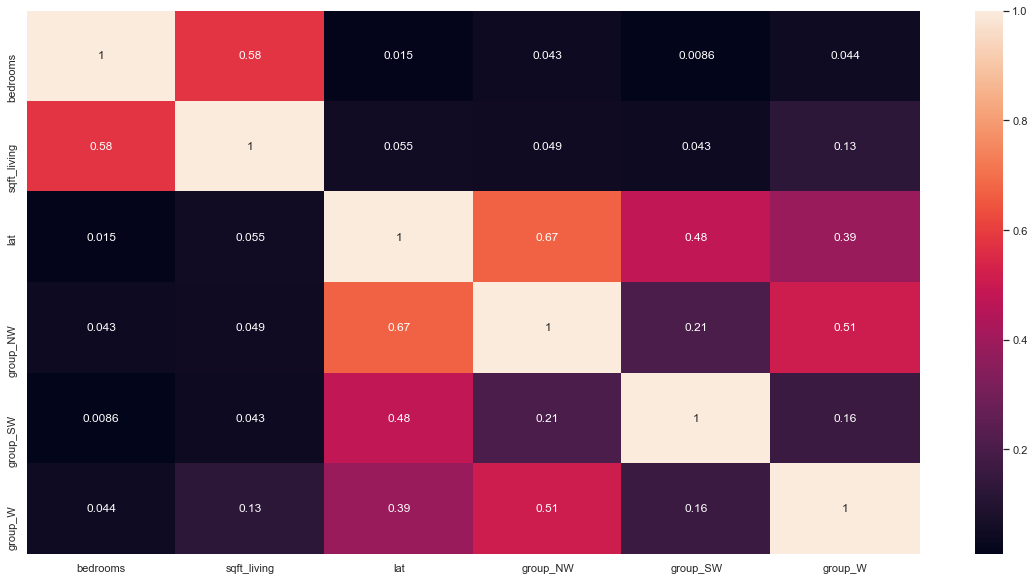

In [59]:
sns.heatmap(X_train_scaled.filter(['bedrooms', 'sqft_living', 'lat','log_water', 'group_NW','group_SW','group_W'],axis=1).corr().abs(),annot=True)

The interpretation of a regression coefficient is that it represents the average change in the dependent variable for each 1 unit change in a predictor, assuming that all the other predictor variables are kept constant. But, when multicolinearity is observed, it complicates this interpretation. With multicolinearity, 1 unit change in a predictor can not only change the dependent variable, but also another independent variable. Since multicollinearity is less than 0.7 between each of the variables, we can deem that the model is not multicollinear.

 # Undervalued Homes

A house flipper's main concern is to find which homes are being sold at a lower price in the market than its supposed value. Thus, my using the price predictor from our model, we aimed to pinpoint undervalued homes. We first combined the Train and Test datasets, adding on the longitude and latitude information onto it as well. Then, we created a new column to measure the difference in actual price and predicted price. From price_table_final, we filtered out homes that had a positive price difference, which means that its predicted price is higher than the actual price that it was sold.

In [60]:
#resetting the index before concatenating the Train and Test datasets
y_test.reset_index(drop=True,inplace=True)
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
#Concatenating the long, lat, actual price, and predicted price of both the Train and Test datasets
price_table1 = pd.concat((X_train.long,X_train.lat,y_train,y_hat_train),axis=1)
price_table2 = pd.concat((X_test.long,X_test.lat,y_test,y_test_pred),axis=1)
price_table_final = pd.concat((price_table1,price_table2),axis=0)
price_table_final.columns = ['long','lat','actual_price','pred_price']
#making a new column for difference in price
price_table_final['price_diff']=price_table_final["pred_price"]-price_table_final['actual_price']
#dataset with homes that have a higher predicted price than actual price
price_table_pos = price_table_final.loc[price_table_final['price_diff']>0]
price_table_pos

,long,lat,actual_price,pred_price,price_diff
2,-122.168,47.3491,274900,2.947943e+05,19894.291945
4,-122.062,47.3555,430760,5.529996e+05,122239.566137
10,-122.078,47.5524,1350000,1.403842e+06,53842.351533
12,-122.114,47.5451,900000,1.894102e+06,994102.448271
13,-122.016,47.5593,770000,9.266440e+05,156643.975216
...,...,...,...,...,...
4205,-122.319,47.3699,290000,4.097246e+05,119724.592696
4206,-122.297,47.7029,521000,6.582847e+05,137284.661975
4207,-122.194,47.5115,433000,5.599587e+05,126958.665144
4208,-122.267,47.5362,461550,6.276718e+05,166121.833860


One can see the potential average profit yield from this batch of undervalued homes below.

In [61]:
print("Undervalued Homes have an average potential profit yield of: $",price_table_pos['price_diff'].mean())

Undervalued Homes have an average potential profit yield of: $ 134010.35573655998


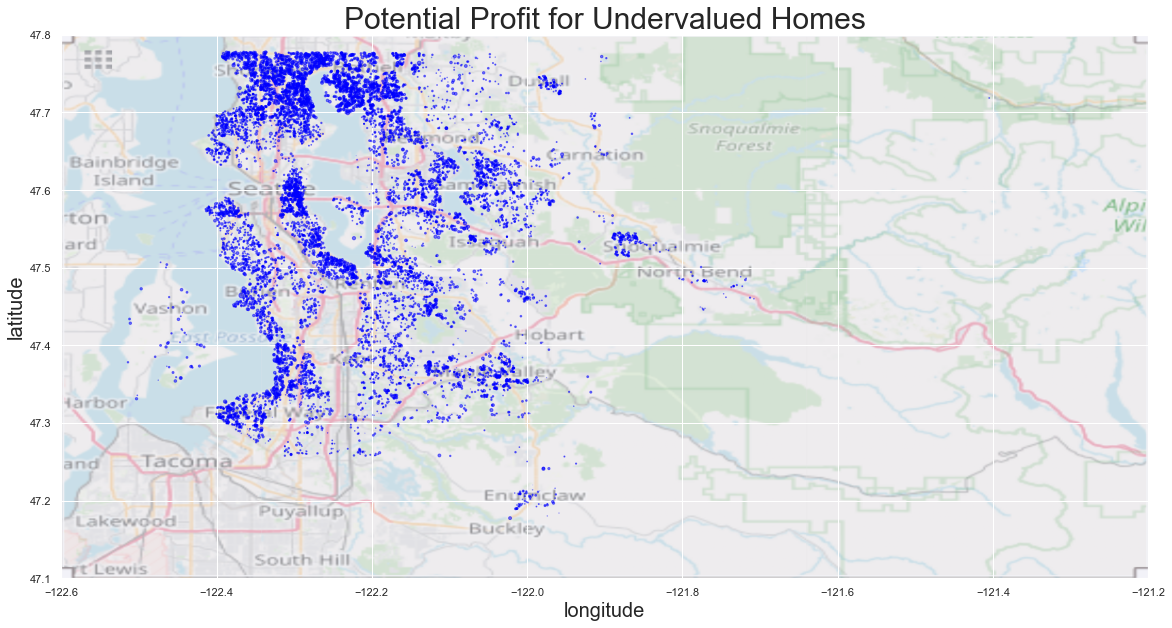

In [64]:
import matplotlib.image as mpimg

fig, ax = plt.subplots(figsize=(20,10))

size = price_table_pos['price_diff']
s = [s/50000 for s in size]

ax.scatter(price_table_pos['long'], price_table_pos['lat'], s=s, alpha=0.5, c='blue')
ax.set_xlabel('longitude', fontsize=20)
ax.set_ylabel('latitude',fontsize=20)
ax.set_title('Potential Profit for Undervalued Homes',fontsize=30)
seattle_img=mpimg.imread('pictures/map_of_seattle.png')
# c is the attribute we'll map onto colors, s is the attribute we'll represent with circle size.
plt.imshow(seattle_img, extent=[-122.6, -121.2, 47.1, 47.8], alpha=0.5);

## Case Study

As a case study, we selected one of the homes near the average potential profit yield metric. By utilizing the coordinates (latitude, longitude) and the zipcode, we were able to search its exact location via Google Maps.

Address: 2751 NE 103rd St.

#### Image of 2751 NE 103rd St. Courtesy of Goolge Street View

![Real World Image of Case Study](pictures/casestudy.png)    

#### Location Via Google Maps

![Google Map Location](pictures/casestudy2.png)

In [65]:
price_table_pos.loc[4206]

long              -122.297000
lat                 47.702900
actual_price    521000.000000
pred_price      658284.661975
price_diff      137284.661975
Name: 4206, dtype: float64

In [66]:
#Cross referencing it to our original dataset
example = df[df['coordinates']=='(47.4997, -122.231)']
pd.set_option('display.max_columns', 36)
example

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,label_rural,label_suburban,label_urban,coordinates,closest_water,group_C,group_E,group_N,group_NE,group_NW,group_S,group_SE,group_SW,group_W,log_water
2041,2568300132,2014-10-08,521000,3,2.0,1870,5455,1.0,NO,NONE,Very Good,7,1060,810,1926,0.0,98125,47.7029,-122.297,1870,7435,0,0,1,"(47.4997, -122.231)",1.702851,0,0,0,0,1,0,0,0,0,0.538159


This example fits our predictions very closely. It is located in the Northwest region of King County, which also is relatively close to water. The size of the living space could be possibly improved to further raise the price. For such homes, Kapaw Consulting can further assist in investigating whether changing the mutable features such as home size, grade, condition, or interior design could potentially raise the home price.

# Further Considerations: Grade as an Additional Factor

In our final model, we unfortunately could not utilize grade due to its high multicollinearity with sqft_living. 
We still believe that grade is a major factor in the price of a home, and while the livable area of a home may contribute to its grade, it is more to do with the quality of the materials and craftsmanship. It is also reasonable to assume someone may want to spend more on higher grade home than on more square feet.

For this section we began by defining a new DataFrame,`df_grade`, in order to preserve previous and future work.

In [67]:
df_grade = pd.read_csv("data/master_data_2.csv")
df_grade


,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,label_rural,label_suburban,label_urban,coordinates,closest_water,group_C,group_E,group_N,group_NE,group_NW,group_S,group_SE,group_SW,group_W
0,0,7129300520,10/13/2014,221900,3,1.00,1180,5650,1.0,NaN,NONE,Average,7,1180,0,1955,0.0,98178,47.5112,-122.257,1340,5650,0,1,0,"(47.5112, -122.257)",0.680220,0,0,0,0,0,0,0,0,1
1,1,6414100192,12/9/2014,538000,3,2.25,2570,7242,2.0,NO,NONE,Average,7,2170,400,1951,1991.0,98125,47.7210,-122.319,1690,7639,0,0,1,"(47.721, -122.319)",2.915718,0,0,0,0,1,0,0,0,0
2,2,5631500400,2/25/2015,180000,2,1.00,770,10000,1.0,NO,NONE,Average,6,770,0,1933,NaN,98028,47.7379,-122.233,2720,8062,0,1,0,"(47.7379, -122.233)",2.331581,0,0,0,0,1,0,0,0,0
3,3,2487200875,12/9/2014,604000,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7,1050,910,1965,0.0,98136,47.5208,-122.393,1360,5000,0,0,1,"(47.5208, -122.393)",0.466960,0,0,0,0,0,0,0,0,1
4,4,1954400510,2/18/2015,510000,3,2.00,1680,8080,1.0,NO,NONE,Average,8,1680,0,1987,0.0,98074,47.6168,-122.045,1800,7503,0,1,0,"(47.6168, -122.045)",1.729957,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21054,21415,263000018,5/21/2014,360000,3,2.50,1530,1131,3.0,NO,NONE,Average,8,1530,0,2009,0.0,98103,47.6993,-122.346,1530,1509,0,0,1,NaN,5.356536,0,0,0,0,1,0,0,0,0
21055,21416,6600060120,2/23/2015,400000,4,2.50,2310,5813,2.0,NO,NONE,Average,8,2310,0,2014,0.0,98146,47.5107,-122.362,1830,7200,0,1,0,NaN,1.725096,0,0,0,0,0,0,0,0,1
21056,21417,1523300141,6/23/2014,402101,2,0.75,1020,1350,2.0,NO,NONE,Average,7,1020,0,2009,0.0,98144,47.5944,-122.299,1020,2007,0,0,1,NaN,0.926910,0,0,0,0,1,0,0,0,0
21057,21418,291310100,1/16/2015,400000,3,2.50,1600,2388,2.0,NaN,NONE,Average,8,1600,0,2004,0.0,98027,47.5345,-122.069,1410,1287,0,1,0,NaN,2.400465,1,0,0,0,0,0,0,0,0


We then saved the `price`, `grade`, and `sqft_living` columns as their own DataFrame, `grade_redux`, for future data manipulation.

In [68]:
grade_redux = df_grade[["price","grade","sqft_living"]]

We decided to run a statmodel ols linear regression test. Like all our other linear regressions, we split it into a 80% train and 20% test data. These were all had `_g` added to their variables as to not affect other testing in the notebook with this simplified regression model.

In [69]:
y_g = grade_redux.price
X_g = grade_redux.drop('price', axis=1) 

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_g, 
                                                    y_g,
                                                    test_size=0.2,
                                                    random_state=33)

We luckily since we only have one variable we are examining, there is no need for us to standard scale. So we move on to fitting our training data to our model using statmodels's ols feature

In [70]:
train_g_final = pd.concat((X_train_g,y_train_g),axis=1)

formula = 'price ~ grade'
model_grade_train = ols(formula=formula, data=train_g_final)
results = model_grade_train.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                 1.357e+04
Date:                Sat, 19 Feb 2022   Prob (F-statistic):               0.00
Time:                        16:15:13   Log-Likelihood:            -2.3465e+05
No. Observations:               16847   AIC:                         4.693e+05
Df Residuals:                   16845   BIC:                         4.693e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.061e+06   1.39e+04    -76.391      0.000   -1.09e+06   -1.03e+06
grade        2.09e+05   1793.842    116.485      0.000    2.05e+05    2.12e+05
==============================================================================
Omnibus:                    13508.847   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           689235.834
Skew:                           3.471   Prob(JB):                         0.00
Kurtosis:                      33.556   Cond. No.                         52.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### The above states that our simple model that includes the grade as our only inferential perameter predicts 44.6% of the variation in home prices in our training data. Our coefficent tells us that for every change in one numeric grade, we see, on average, a jump in home price of \$210,000.

Next we wanted to see our median price, median sqft_living, and median price per sqft_living for each group. This was accomplished by grouping `price` and `sqft_living` by grade in a new DataFrame. We then added a new value which calculated price per square foot. We used median to eliminate any outliers that were skewing our data.

In [71]:
med_price_by_grade = grade_redux.groupby(['grade']).median(['price','sqft_living'])
ind = med_price_by_grade.index
med_price_by_grade["price_per_sqft_liv"] = med_price_by_grade['price']/med_price_by_grade['sqft_living']

med_price_by_grade


,price,sqft_living,price_per_sqft_liv
grade,,,
3,262000.0,520.0,503.846154
4,200000.0,700.0,285.714286
5,226225.0,900.0,251.361111
6,275000.0,1120.0,245.535714
7,375000.0,1630.0,230.061350
8,510000.0,2150.0,237.209302
9,723000.0,2811.0,257.203842
10,916000.0,3450.0,265.507246
11,1280000.0,4227.5,302.779420


We then graphed both of these results below.

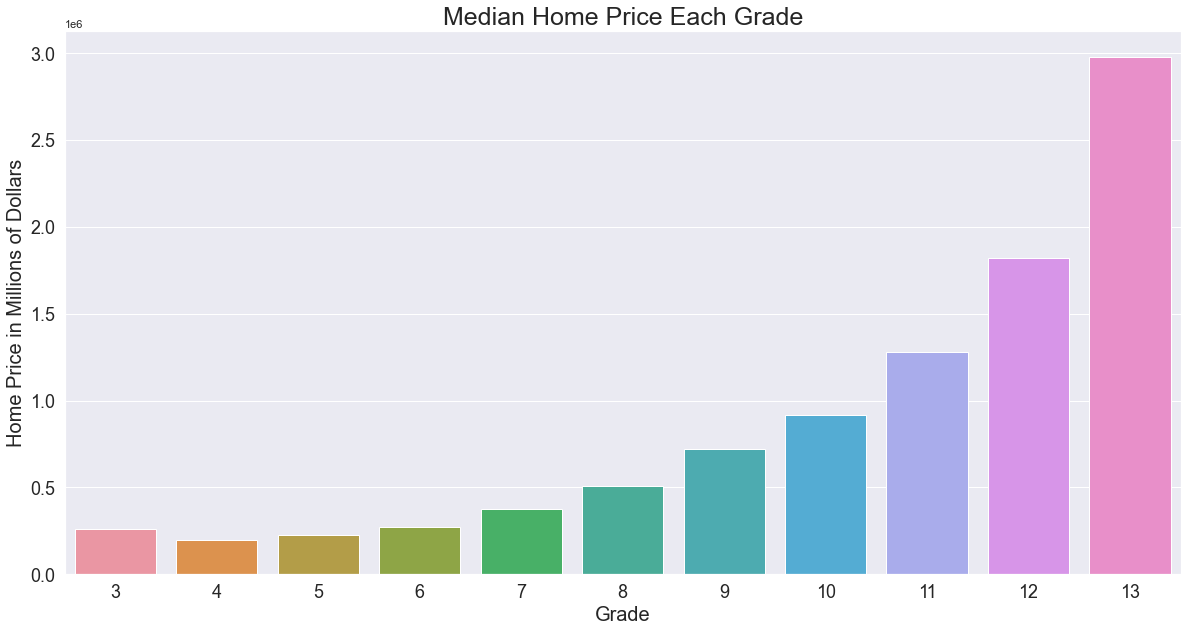

In [72]:
ax = sns.barplot(x = ind,  y = med_price_by_grade["price"])

ax.set_xlabel("Grade", fontsize = 20)
ax.set_ylabel("Home Price in Millions of Dollars", fontsize = 20)
ax.set_title("Median Home Price Each Grade", fontsize = 25)

plt.tick_params(axis='both', which='major', labelsize=18)


#### Now that we see this visually, we consider if this makes sense. 
At first, the grade 3's appear to have a median price higher than the grade 4's and 5's! However, if we do a quick value count of grades,


In [73]:
df_grade.grade.value_counts()

7     8779
8     5965
9     2527
6     1967
10    1096
11     378
5      226
12      80
4       27
13      13
3        1
Name: grade, dtype: int64

### We see that there is only a single grade 3 home in our data! 
We will consider the single grade 3 home an unusually highly priced home (most likely an outlier if we had more grade 3 homes to compare it to) and move on. 

Moving on to grade 4, we can visually see that the lowest grade homes have the lowest median home price and the highest grade, grade 13, have the highest price. This makes sense. Next we will further examine the price per sqft for each grade.

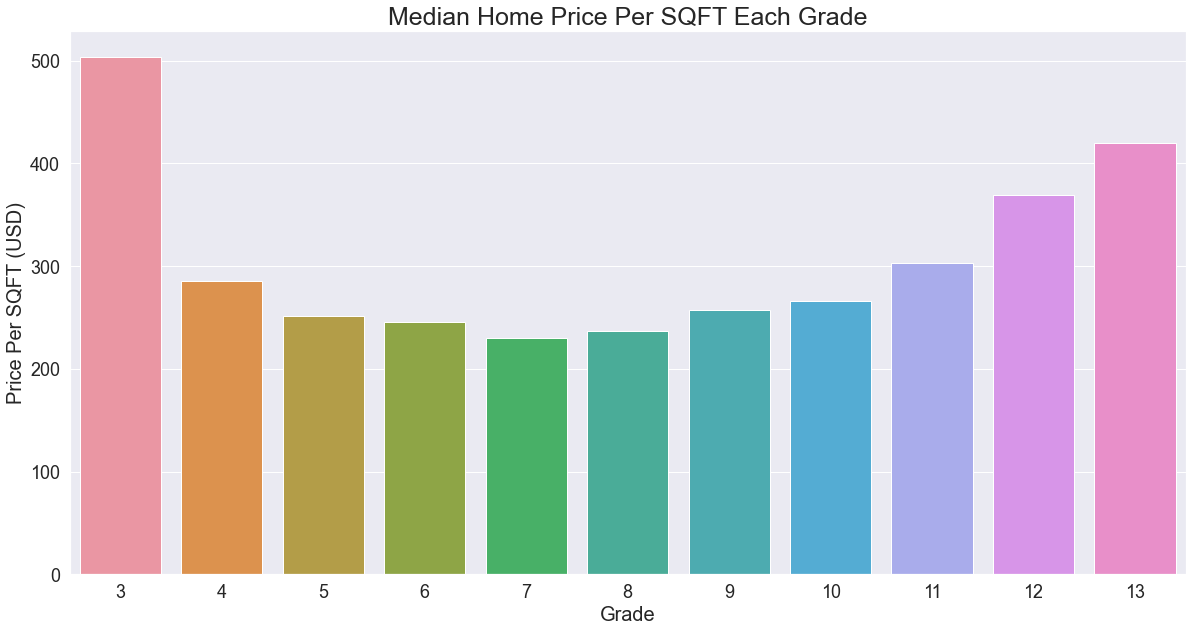

In [82]:
ax = sns.barplot(x = ind,  y = med_price_by_grade["price_per_sqft_liv"])
ax.set_xlabel("Grade", fontsize = 20)
ax.set_ylabel("Price Per SQFT (USD)", fontsize = 20)
ax.set_title("Median Home Price Per SQFT Each Grade", fontsize = 25)
plt.tick_params(axis='both', which='major', labelsize=18)


#### At first glance this again may not make sense! 
How can the lowest grade in our model have the absolute highest median price square foot?!
We recall that we considered our single grade 3 home a probable outlier, skewing our data. 

But even if that is true, our price seems to decrease from grades 4 to to 7 before going back up as we would expect! Perhaps something is "diluting" the price per square foot? We looked at our 'med_price_by_grade' dataframe to see what was going on. 

In [83]:
med_price_by_grade

,price,sqft_living,price_per_sqft_liv,percent_change_by_grade,label
grade,,,,,
3,262000.0,520.0,503.846154,NaN,2 to 3
4,200000.0,700.0,285.714286,-43.293348,3 to 4
5,226225.0,900.0,251.361111,-12.023611,4 to 5
6,275000.0,1120.0,245.535714,-2.317541,5 to 6
7,375000.0,1630.0,230.061350,-6.302287,6 to 7
8,510000.0,2150.0,237.209302,3.106977,7 to 8
9,723000.0,2811.0,257.203842,8.429071,8 to 9
10,916000.0,3450.0,265.507246,3.228336,9 to 10
11,1280000.0,4227.5,302.779420,14.038101,10 to 11


It can be seen that because our sqft_living value is continually increasing, this causes our "dilution" of price per sqft value. Jumping from grade 4 to 5, our sqft_living increases by 28.5%, while their respective prices are only a 13.1% change. Any time our price change percentage is beaten by our sqft_living percentage, we have "diluted" our value per sqft of our homes. 

Looking at the change from grade 10 to 11 we have a 22% increase in living space and a 39.7% change in price, registering as a positive change on our graph.


We then created a new category that is the percent change between each grade. As we had no grade 1 or 2 houses, we could not get the difference in price between them or for our grade 3 homes. We also must throw out the grade 4 result as our probable outlier grade 3 has skewed it . These results were then graphed as both a bar and line graph. 

In [84]:
med_price_by_grade["percent_change_by_grade"] = med_price_by_grade["price_per_sqft_liv"].pct_change() * 100

    

In [85]:
med_price_by_grade

,price,sqft_living,price_per_sqft_liv,percent_change_by_grade,label
grade,,,,,
3,262000.0,520.0,503.846154,NaN,2 to 3
4,200000.0,700.0,285.714286,-43.293348,3 to 4
5,226225.0,900.0,251.361111,-12.023611,4 to 5
6,275000.0,1120.0,245.535714,-2.317541,5 to 6
7,375000.0,1630.0,230.061350,-6.302287,6 to 7
8,510000.0,2150.0,237.209302,3.106977,7 to 8
9,723000.0,2811.0,257.203842,8.429071,8 to 9
10,916000.0,3450.0,265.507246,3.228336,9 to 10
11,1280000.0,4227.5,302.779420,14.038101,10 to 11


We can see that our grade 3 has no result for percent change and our grade 4 has been massively skewed and should be ignored unless we obtain more data in the future. We then graphed our remaining results to visually interpret them.

In [86]:
label_col = med_price_by_grade
label_col["label"] = label_col.index.map(lambda x: f'{x-1} to {x}')
label_5 = np.array(label_col.label[2:])


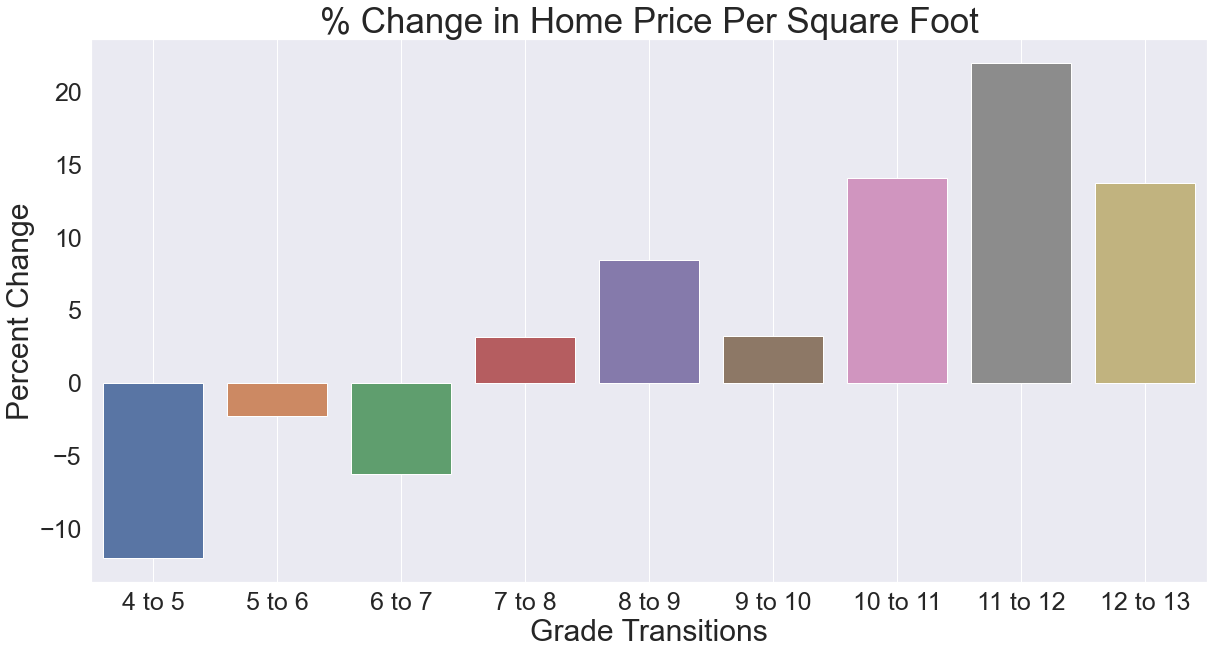

In [91]:
ax = sns.barplot(x=label_5, y = med_price_by_grade.percent_change_by_grade[2:])
ax.set_xlabel("Grade Transitions", fontsize = 30)
ax.set_ylabel("Percent Change", fontsize = 30)
ax.set_title("% Change in Home Price Per Square Foot", fontsize = 35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.grid();


As you can see, it would be best practice to begin with a grade 7 or lower house, then during a flip, rennovate the home until it is a grade 8 or higher as there are massive possible profit gains.


# Conclusion

Our data analysis suggests that price has a statistically significant correlation with the size of living space, closeness to water, and the region in which it is located in. By employing a multiple regression model with the aforementioned features, we were able to extract all of the undervalued homes from the original dataset. Homes that had a higher predicted price in the model than the actual price fit the criteria of undervalued homes. The KaPow Consulting Team recommends that our stakeholders invest in such undervalued homes, as they may have a higher potential for profit yield. The case study conducted at the end goes further to demonstrate how much profit could be up for grabs.